In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre, hermite
from scipy.integrate import nquad, quad, dblquad
from itertools import product
from numba import njit

In [2]:
@njit
def function(Z1, Z2):
    """
    Calculate the value of the given function.

    Args:
        Z1 (float): First input parameter.
        Z2 (float): Second input parameter.

    Returns:
        float: The value of the mathematical function.
    """
    # adapted such that no coordinate transformation is necessary
    return -(Z1) * (Z2)**3 + np.exp(-0.5*(Z1)**2 - 0.1 * (Z2)**2)

def get_pairs(max_order, dims=2):
    """
    Generate pairs of integers where sum of each pair is less than or equal to max_order.

    Args:
        max_order (int): The maximum integer value for pairs.
        dims (int, optional): Number of dimensions for the pairs. Default is 2.

    Returns:
        list: List of pairs of integers.
    """
    pairs = []
    for pair in product(np.arange(0, max_order), repeat=dims):
        if sum(pair) <= max_order:
            pairs.append(pair)
    return pairs

@njit
def normal_pdf(x, mu=0, sigma=1):
    """
    Calculate the probability density function (PDF) of a normal (Gaussian) distribution.

    Args:
        x (float or ndarray): The value(s) at which to evaluate the PDF.
        mu (float, optional): The mean (average) of the normal distribution. Default is 0.
        sigma (float, optional): The standard deviation of the normal distribution. Default is 1.

    Returns:
        float or ndarray: The PDF value(s) at the specified input value(s).
    """
    return 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

def integral_nominator(Z1, Z2, phi1, phi2):
    """
    Calculate the integrand for a specific pair of Legendre and Hermite polynomials.

    Args:
        Z1 (float): First input parameter.
        Z2 (float): Second input parameter.
        phi1 : Legendre polynomial
        phi2 : Hermite polynomials.

    Returns:
        float: The value of the integrand.
    """
    f = function(Z1, Z2) # calculate f with transformed variables
    return f * phi1(Z1) * phi2(Z2) * 0.5 * normal_pdf(Z2)

def inner_leg(z, order):
    """
    Calculate the inner product of a Legendre polynomial of a given order.

    Args:
        z (float): The input value at which to evaluate the Legendre polynomial.
        order (int): The order of the Legendre polynomial.

    Returns:
        float: The inner product value.
    """
    phi = legendre(order)
    return phi(z) * phi(z) * 0.5

def inner_her(z, order):
    """
    Calculate the inner product of a Hermite polynomial of a given order.

    Args:
        z (float): The input value at which to evaluate the Hermite polynomial.
        order (int): The order of the Hermite polynomial.

    Returns:
        float: The inner product value.
    """
    phi = hermite(order) 
    return phi(z) * phi(z) * normal_pdf(z)

def get_coefficents(max_order, dims=2):
    """
    Calculate coefficients for the pairs of Legendre and Hermite polynomials.

    Args:
        max_order (int): The maximum order for Legendre and Hermite polynomials.
        dims (int, optional): Number of dimensions. Default is 2.

    Returns:
        tuple: A tuple containing pairs of Legendre and Hermite polynomials, and their coefficients.
    """
    pairs = get_pairs(max_order, dims)

    # Pre-calculate gamma's so we can reuse them
    gamma1s = []
    gamma2s = []
    for i in range(max_order+1):
            gamma1s.append(quad(inner_leg, -1, 1, args=i)[0])
            gamma2s.append(quad(inner_her, -np.inf, np.inf, args=i)[0])
            if i%10 == 0:
                print(i," of ",max_order+1," iterations")

    fhats = []
    for i, pair in enumerate(pairs):
        phi1 = legendre(pair[0])  # This line uses legendre, make sure it is imported or defined.
        phi2 = hermite(pair[1])  # This line uses hermite, make sure it is imported or defined.
        nominator = nquad(integral_nominator, [[-1, 1], [-np.inf, np.inf]], args=[phi1, phi2])[0]
        fhats.append(nominator / (gamma1s[pair[0]] * gamma2s[pair[1]]))
        if i%100 == 0:
            print(i," of ",len(pairs)," iterations")

    return pairs, fhats

def proj_eval(z1, z2, pairs, fhats):
    """
    Evaluate the projection of the function onto a set of basis functions.

    Args:
        z1 (array-like): Input values for the first dimension.
        z2 (array-like): Input values for the second dimension.
        pairs (list): List of pairs representing Legendre and Hermite polynomial orders.
        fhats (list): List of coefficients for each pair.

    Returns:
        ndarray: The projection matrix.
    """
    proj = np.zeros((len(z1), len(z1)))
    for i, pair in enumerate(pairs):
        proj += fhats[i] * legendre(pair[0])(z1) * hermite(pair[1])(z2)  # This line uses legendre and hermite, make sure they are imported or defined.

    return proj


In [3]:
X, Y = np.meshgrid(np.linspace(-1,1,1000), np.linspace(-3,3,1000))
Zf = function(X,Y)

In [4]:
np.mean(Zf)

0.6551523875256017

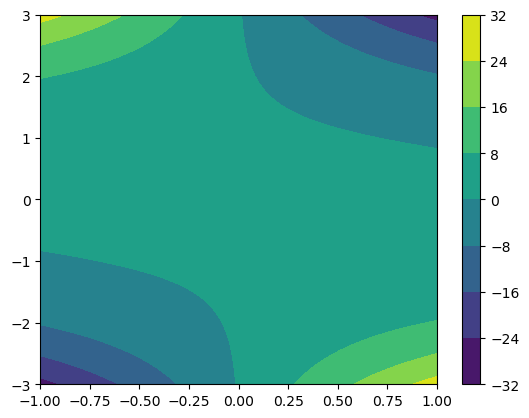

In [5]:
plt.contourf(X,Y,Zf)
plt.colorbar()

In [6]:
# max_order = 10
# pairs, fhats = get_coefficents(max_order)

In [7]:
max_order = 100
pairs = get_pairs(max_order)
fhats = np.load('fhats_100.npy')

In [8]:
# np.save('fhats_100',fhats)

Zp = proj_eval(X,Y,pairs,fhats)

/Users/nik/opt/miniconda3/envs/IntroCLS/lib/python3.10/site-packages/scipy/special/_orthogonal.py:121: RuntimeWarning: invalid value encountered in sqrt
  mu = sqrt(hn)


KeyboardInterrupt: 

In [ ]:
Zp

array([[-55.81682756, -55.69900536, -55.58118318, ...,  58.62924278,
         58.74098929,  58.85273579],
       [-55.28989285, -55.17314917, -55.05640551, ...,  58.09263095,
         58.20332254,  58.31401411],
       [-54.76791481, -54.6522396 , -54.53656441, ...,  57.56101749,
         57.67066407,  57.78031064],
       ...,
       [ 57.78031064,  57.67066407,  57.56101749, ..., -54.53656441,
        -54.6522396 , -54.76791481],
       [ 58.31401411,  58.20332254,  58.09263095, ..., -55.05640551,
        -55.17314917, -55.28989285],
       [ 58.85273579,  58.74098929,  58.62924278, ..., -55.58118318,
        -55.69900536, -55.81682756]])

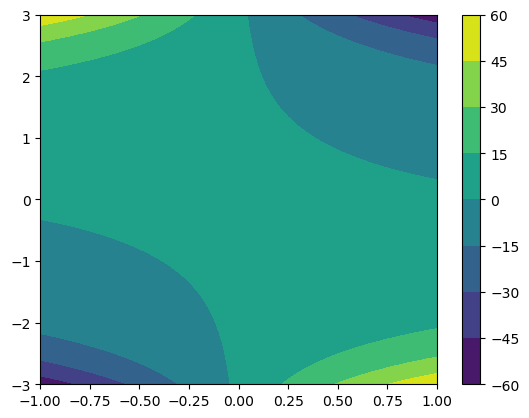

In [ ]:
plt.contourf(X,Y,Zp)
plt.colorbar()

In [11]:
pZ = 1/2 * np.ones(Zf.shape)
pZ = np.multiply(normal_pdf(Y), pZ)
np.sum(pZ)

83027.45124753652

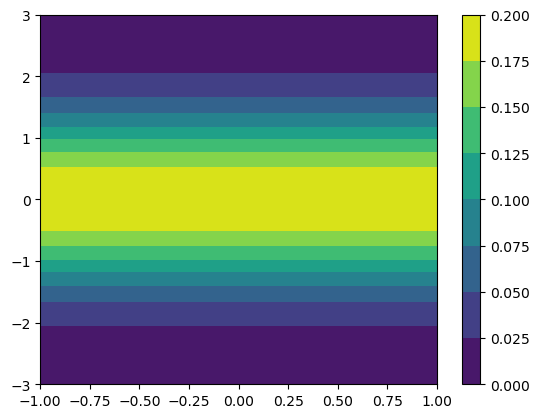

In [12]:
plt.contourf(X,Y,pZ)
plt.colorbar()

In [13]:
np.sum(normal_pdf(np.linspace(-10,10,1000)))

49.95000000000002

In [14]:
plt.contourf(X,Y,Zf-Zp)
plt.colorbar()

NameError: name 'Zp' is not defined

In [15]:
# use the calculated coesfficents to get the errors for lower orders
orders = np.arange(1,max_order)
errors = []

for order in orders:
    ord_pairs = get_pairs(order)
    ord_fhats = []
    for i,pair in enumerate(pairs):
        if pair in ord_pairs:
            ord_fhats.append(fhats[i])
    
    Zp = proj_eval(X,Y,ord_pairs,ord_fhats)
    wE = np.linalg.norm((Zf-Zp)*pZ,2) # np.sqrt(np.sum(((Zf-Zp)*pZ)**2))
    errors.append(np.sum(wE))

LinAlgError: SVD did not converge

In [16]:
len(errors)

40

Text(0, 0.5, 'error')

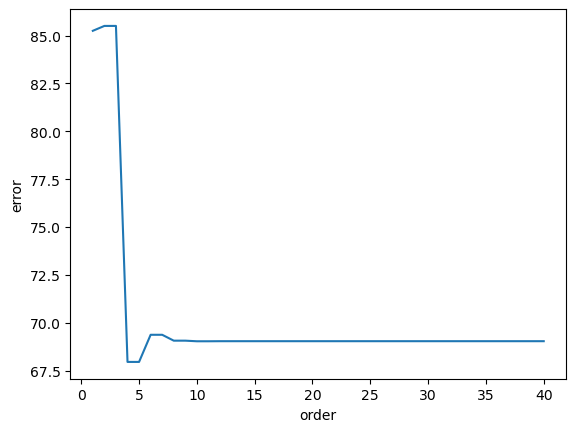

In [17]:
plt.plot(orders[:len(errors)], errors)
plt.xlabel("order")
plt.ylabel("error")

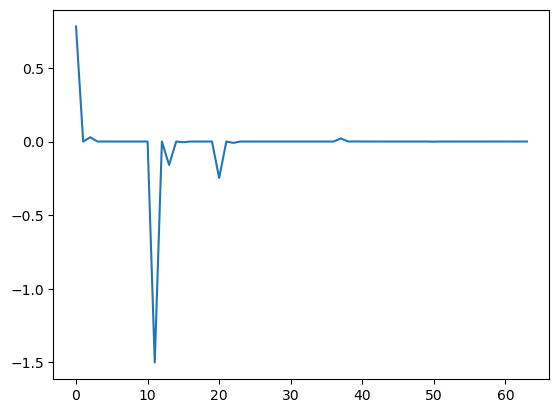

In [ ]:
plt.plot(fhats[:100])

In [22]:
len(ord_pairs)

901